In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

👉 `Estimated Time of Arrival (ETA)` is a key component of modern e-commerce services. It allows companies to manage customer expectations by showing a predicted date for customer delivery.

🎯 In this challenge, we will build a predictive model that `estimates the wait time` of an order.

☑️ Olist already has its own predictions under the variable `expected_wait_time`

🚀 Let's challenge ourselves to do better predictions and at the end of this recap, 
we will compare:
* our `estimated_wait_time`
* Olist's `expected_wait_time`
* the real `wait_time` for each order delivered

## Load and check `orders` dataset

👉 `Order().get_training_data()` (include `distance_seller_customer`)

In [1]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [2]:
orders.head(3)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


## Baseline Model - Olist’s current ETA model

🐣  What's the baseline we want to optimize ❓

👉 The delta between Olist' `expected_wait_time` and the real `wait_time`

📈 Plot their respective histograms

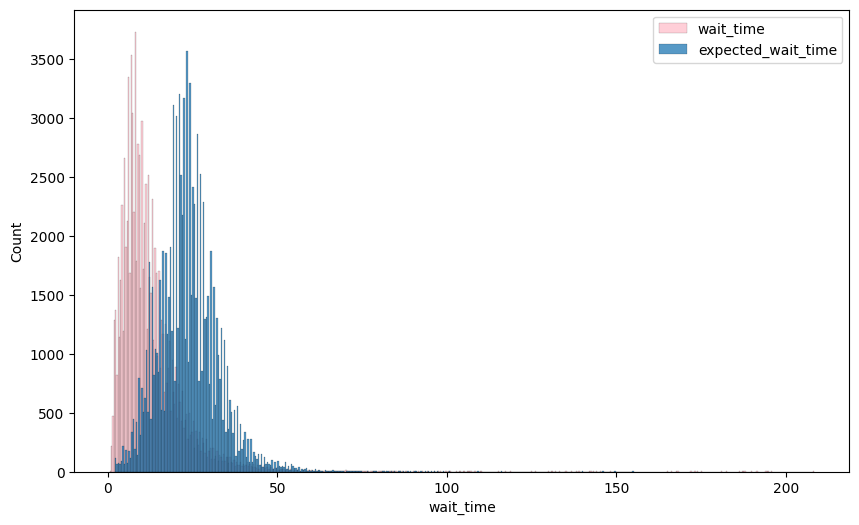

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(data=orders, x="wait_time", label="wait_time", color="pink")
sns.histplot(data=orders, x="expected_wait_time", label="expected_wait_time")
plt.legend()

👉 What is the median wait time ? the median expected wait time ? 

In [17]:
orders["wait_time"].agg({"mean", "median"})

mean      12.513442
median    10.203727
Name: wait_time, dtype: float64

In [18]:
orders["expected_wait_time"].agg({"mean", "median"})

mean      23.739059
median    23.230556
Name: expected_wait_time, dtype: float64

👉 Compute the baseline RMSE 

ℹ️ The errors considered here are the misapproximations from Olist in terms of waiting time.

In [53]:
errors = orders["expected_wait_time"] - orders["wait_time"]
baseline_RMSE = (errors ** 2).mean() ** 0.5
baseline_RMSE

15.110701386210625

## OLS multivariate model

👉 We will create an OLS model using the `statsmodel.api.OLS` method this time.

(instead of `statsmodel.formula.api.ols`) 

### Prepare the dataset with the  features X and the target Y

In [22]:
y = orders["wait_time"]
y

0         8.436574
1        13.782037
2         9.394213
3        13.208750
4         2.873877
           ...    
95875     8.218009
95876    22.193727
95877    24.859421
95878    17.086424
95879     7.674306
Name: wait_time, Length: 95872, dtype: float64

In [23]:
# distance_seller_customer, number_of_sellers, freight_value, price, number_of_productsx
orders.head(10)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037
5,a4591c265e18cb1dcee52889e2d8acc3,16.542245,22.085359,0.0,delivered,0,0,4,1,1,147.90,27.36,411.952997
6,6514b8ad8028c9f2cc2374ded245783f,9.989826,21.451042,0.0,delivered,1,0,5,1,1,59.99,15.17,321.730402
7,76c6e866289321a7c93b82b54852dc33,9.818762,41.229757,0.0,delivered,0,1,1,1,1,19.90,16.05,872.669300
8,e69bfb5eb88e0ed6a785585b27e16dbf,18.221852,24.503449,0.0,delivered,1,0,5,1,1,149.99,19.77,111.517726
9,e6ce16cb79ec1d90b1da9085a6118aeb,12.650937,21.179745,0.0,delivered,0,1,1,2,1,198.00,61.06,413.252187


In [25]:
X = orders[["distance_seller_customer", "number_of_sellers", "freight_value", "price", "number_of_products"]]
X

,distance_seller_customer,number_of_sellers,freight_value,price,number_of_products
0,18.063837,1,8.72,29.99,1
1,856.292580,1,22.76,118.70,1
2,514.130333,1,19.22,159.90,1
3,1822.800366,1,27.20,45.00,1
4,30.174037,1,8.72,19.90,1
...,...,...,...,...,...
95875,69.481037,1,13.08,72.00,1
95876,474.098245,1,20.10,174.90,1
95877,968.051192,1,65.02,205.99,1
95878,370.146853,1,81.18,359.98,2


⚖️ Standardize (`z-score`) each feature of X to compare regression coefficients that will result from the OLS:

In [26]:
def standardized_x(df, features):
    standardize_df = df.copy()
    for feature in features:
        standardize_df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    
    return standardize_df

In [32]:
x_standard = standardized_x(X, X.columns)
x_standard["intercept"] = 1
x_standard

,distance_seller_customer,number_of_sellers,freight_value,price,number_of_products,intercept
0,-0.979475,-0.112544,-0.652038,-0.513802,-0.264595,1
1,0.429743,-0.112544,0.000467,-0.086640,-0.264595,1
2,-0.145495,-0.112544,-0.164053,0.111748,-0.264595,1
3,2.054621,-0.112544,0.206815,-0.441525,-0.264595,1
4,-0.959115,-0.112544,-0.652038,-0.562388,-0.264595,1
...,...,...,...,...,...,...
95875,-0.893033,-0.112544,-0.449408,-0.311513,-0.264595,1
95876,-0.212797,-0.112544,-0.123156,0.183977,-0.264595,1
95877,0.617630,-0.112544,1.964490,0.333684,-0.264595,1
95878,-0.387558,-0.112544,2.715522,1.075186,1.601605,1


In [31]:
# Check how different is it from the "formula" in statsmodel
import patsy
patsy.dmatrix('price + distance_seller_customer', orders)

DesignMatrix with shape (95872, 3)
  Intercept   price  distance_seller_customer
          1   29.99                  18.06384
          1  118.70                 856.29258
          1  159.90                 514.13033
          1   45.00                1822.80037
          1   19.90                  30.17404
          1  147.90                 411.95300
          1   59.99                 321.73040
          1   19.90                 872.66930
          1  149.99                 111.51773
          1  198.00                 413.25219
          1   98.00                 844.97722
          1   31.90                 452.20571
          1   19.90                 308.45551
          1   38.25                 430.59899
          1  132.40                 161.60460
          1   27.99                 547.73905
          1   17.90                 209.39770
          1   76.00                1434.17366
          1  109.90                  11.84639
          1   79.99                  19.27366

⚠️ With this `statsmodel.api.OLS`, we always need to add a constant "intercept" to the features dataset:

In [39]:
model = sm.OLS(y, x_standard).fit()
y_pred = model.predict(x_standard)
y_pred

0         8.744923
1        14.145283
2        12.023631
3        19.982926
4         8.814322
           ...    
95875     9.188461
95876    11.816170
95877    16.082243
95878    12.478062
95879    12.674033
Length: 95872, dtype: float64

### Run OLS with `statsmodels` and print `summary`

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3676.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:31:33   Log-Likelihood:            -3.4301e+05
No. Observations:               95872   AIC:                         6.860e+05
Df Residuals:                   95866   BIC:                         6.861e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
distance_seller_customer     3.5219      0.030    117.298      0.000       3.463       3.581
number_of_sellers           -0.3557      0.029    -12.174      0.000      -0.413      -0.298
freight_value                0.6392      0.036     17.717      0.000       0.568       0.710
price                        0.0474      0.031      1.542      0.123      -0.013       0.108
number_of_products          -0.3104      0.033     -9.481      0.000      -0.375      -0.246
intercept                   12.5134      0.028    447.350      0.000      12.459      12.568
==============================================================================
Omnibus:                    91515.661   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10123039.937
Skew:                           4.333   Prob(JB):                         0.00
Kurtosis:                      52.589   Cond. No.                         2.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check the performance of your OLS model

### Goodness of fit

👉 Who has the best predictions, you or Olist ? 

- Compute your predictions and store them in `y_pred`

- You can store :
    - Olist's predictions in a `y_expected_olist` variable
    - the real waiting times in a `y_true` variable



In [41]:
y_pred

0         8.744923
1        14.145283
2        12.023631
3        19.982926
4         8.814322
           ...    
95875     9.188461
95876    11.816170
95877    16.082243
95878    12.478062
95879    12.674033
Length: 95872, dtype: float64

In [42]:
y_expected_olist = orders["expected_wait_time"]
y_expected_olist

0        15.544063
1        19.137766
2        26.639711
3        26.188819
4        12.112049
           ...    
95875    18.587442
95876    23.459051
95877    30.384225
95878    37.105243
95879    25.126736
Name: expected_wait_time, Length: 95872, dtype: float64

In [44]:
y_true = orders["wait_time"]
y_true

0         8.436574
1        13.782037
2         9.394213
3        13.208750
4         2.873877
           ...    
95875     8.218009
95876    22.193727
95877    24.859421
95878    17.086424
95879     7.674306
Name: wait_time, Length: 95872, dtype: float64

📈 Plot `y_pred`, `y_expected_olist` and `y_true` on the same graph.

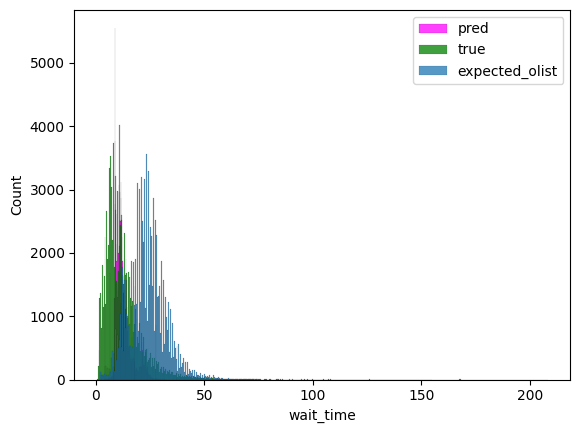

In [48]:
ax1 = sns.histplot(x=y_pred, label="pred", color="fuchsia")
ax2 = sns.histplot(x=y_true, label="true", color="green")
ax3 = sns.histplot(x=y_expected_olist, label="expected_olist")
plt.legend()

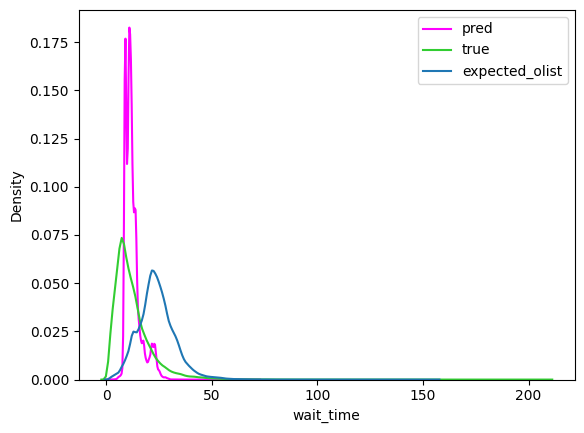

In [50]:
ax1 = sns.kdeplot(x=y_pred, label="pred", color="fuchsia")
ax2 = sns.kdeplot(x=y_true, label="true", color="limegreen")
ax3 = sns.kdeplot(x=y_expected_olist, label="expected_olist")
plt.legend()

👉 Compute the RMSE where the errors are now *your* errors !

In [51]:
((y_pred - y_true) ** 2).mean() ** 0.5

8.660865913751271

Just as a reminder, Olist's RMSE was equal to : 👇

In [54]:
baseline_RMSE

15.110701386210625

😏 Did we really beat Olist's Data Scientists ? We cannot really say that!

- In many e-commerce and delivery services, the ETA is often overestimated...
- When customers receive their orders earlier than expected, they are more likely to be satisfied !

### Partial correlations

👉 Visualize partial correlations with `sm.graphics.plot_partregress_grid`

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


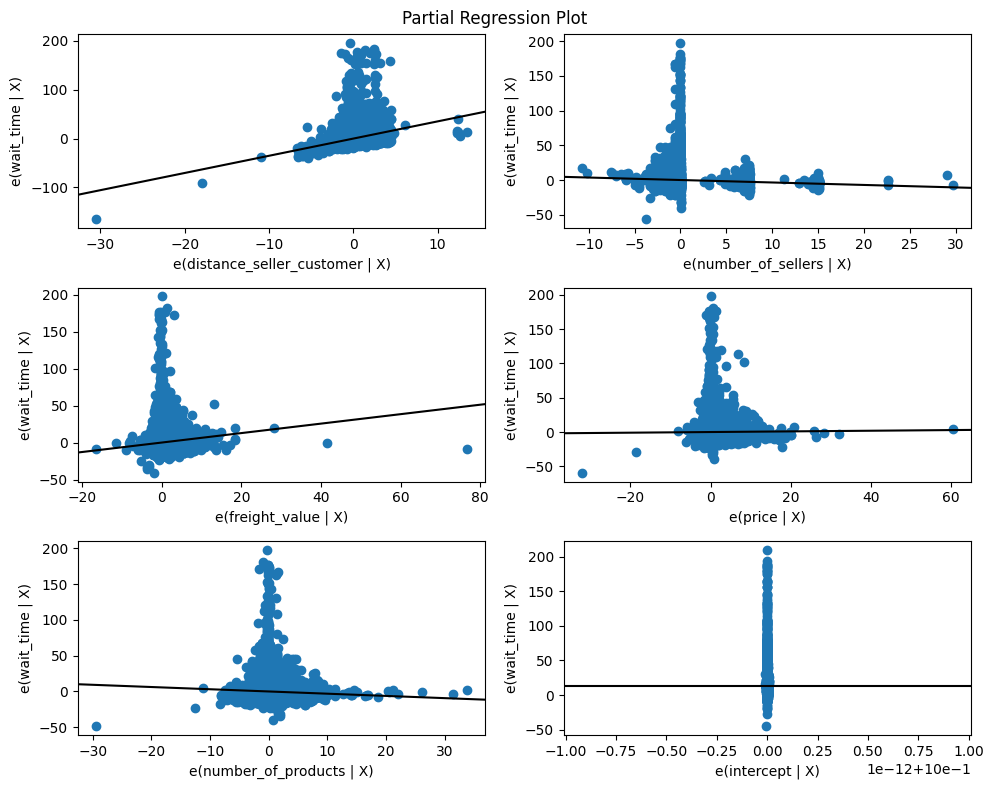

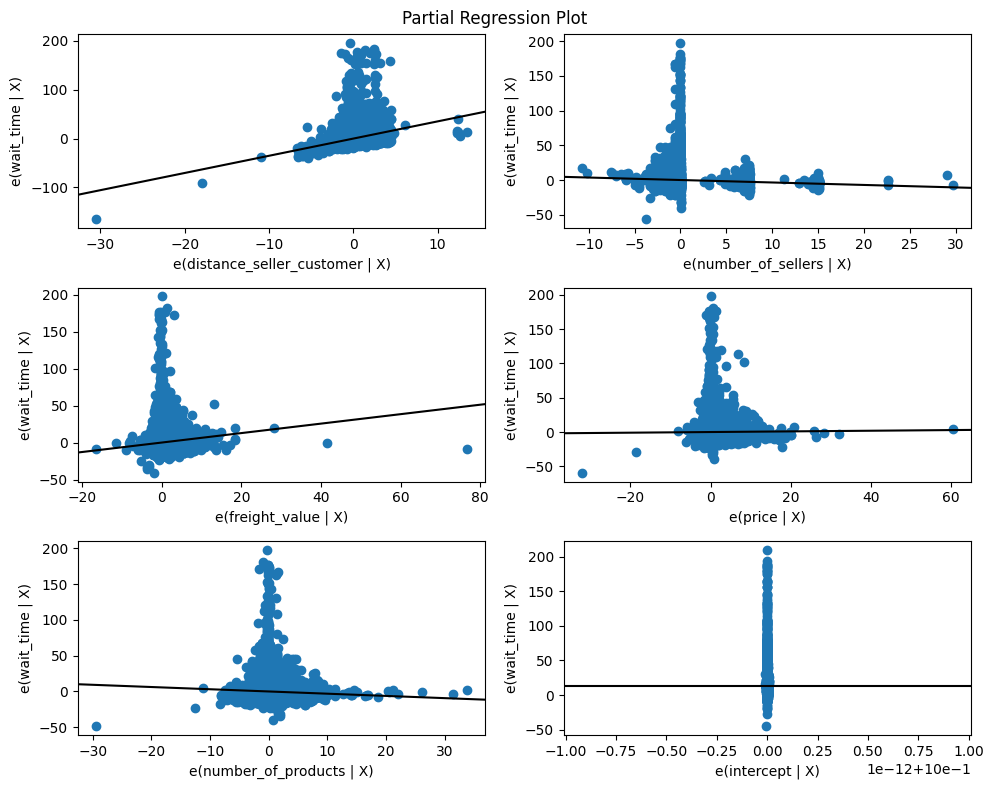

In [56]:
fig = plt.figure(figsize=(10,8))
sm.graphics.plot_partregress_grid(model, fig=fig)

**How do we read these graphs ?**

👉 Let's focus - for instance - on the graph in the bottom left corner:

<u>Partial regression of `wait_time` against `distance`</u>

- Each point is an order in our dataset


- `y-axis`: residuals of the `wait_time`, using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- `x-axis`: residuals of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

⚠️ Check you residuals. Are they normally distributed?

In [69]:
residuals_lewagon = y_pred - orders.wait_time
residuals_lewagon

0         0.308348
1         0.363246
2         2.629418
3         6.774176
4         5.940445
           ...    
95875     0.970452
95876   -10.377557
95877    -8.777179
95878    -4.608361
95879     4.999727
Length: 95872, dtype: float64

In [70]:
model.resid

0        -0.308348
1        -0.363246
2        -2.629418
3        -6.774176
4        -5.940445
           ...    
95875    -0.970452
95876    10.377557
95877     8.777179
95878     4.608361
95879    -4.999727
Length: 95872, dtype: float64

<AxesSubplot:ylabel='Count'>

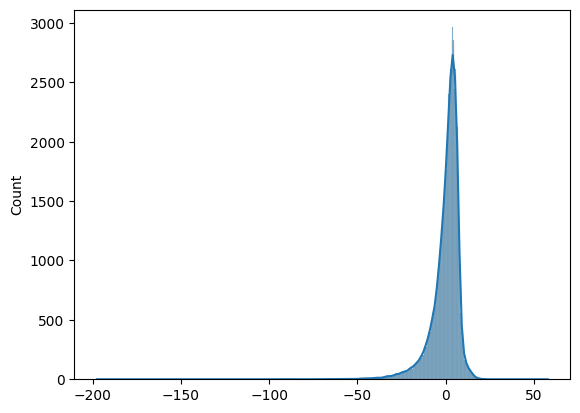

In [71]:
sns.histplot(residuals_lewagon, kde=True)

<AxesSubplot:ylabel='Density'>

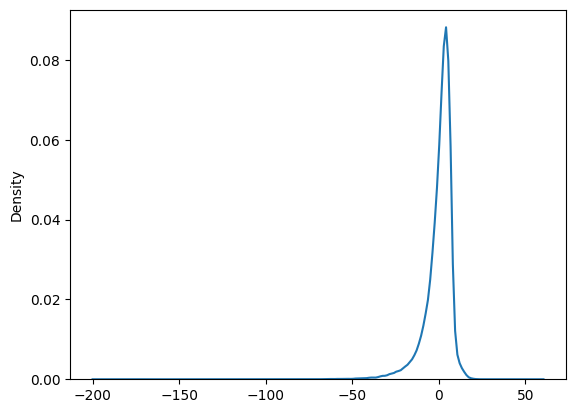

In [73]:
sns.kdeplot(residuals_lewagon)

🎁 A more precise way to visualize whether a distribution is Gaussian or not is the <a href="https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html">**`QQplot`**</a>. 

📈 Plot the QQplot of your residual below

💡 Make sure to understand the relation between the QQ plot and the density previsouly drawn..

📚 <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">Stats.StackExchange.com - Interpreting QQplots</a>

- `x-axis` : theoretical quantiles of a Gaussian distribution
- `y-axis`: quantiles of the sorted variable

💡 If the <span style="color:blue">blue</span> points are aligned on the <span style="color:red">red line</span> which is the identity function, the variable has a Gaussian distribution !

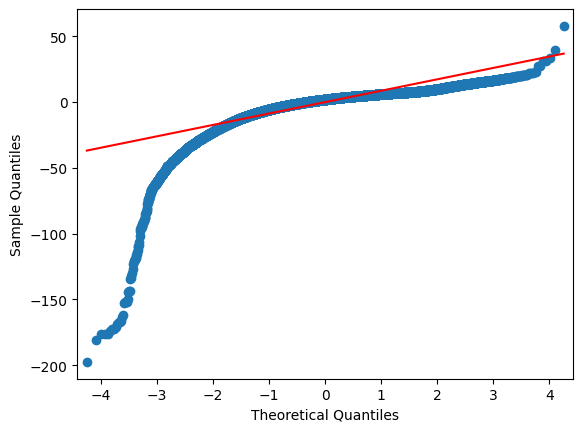

In [79]:
sm.qqplot(residuals_lewagon, line='s');

#### Some QQplot examples:

Run the cells below to understand how QQ plots are graphed:

In [74]:
from scipy import stats 
stats.norm.rvs(0,1)

0.2992515820461273

(-4.774018395033866, 10.0)

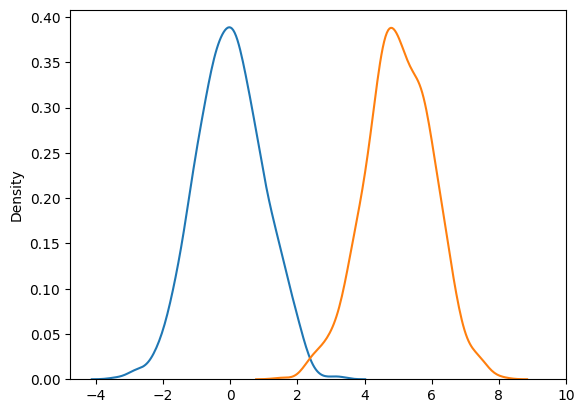

In [75]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

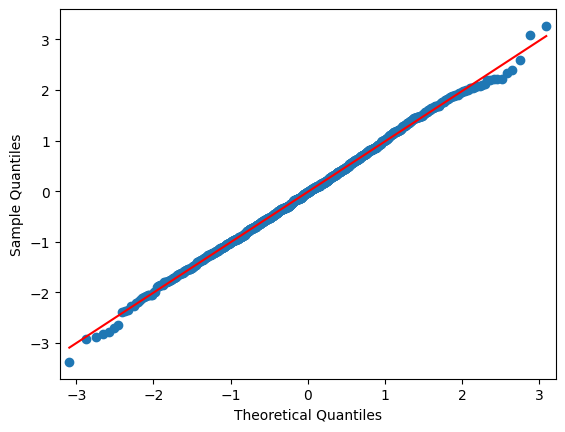

In [76]:
sm.qqplot(np.asarray(norm_1), line='s');

(-5.90013069445817, 10.0)

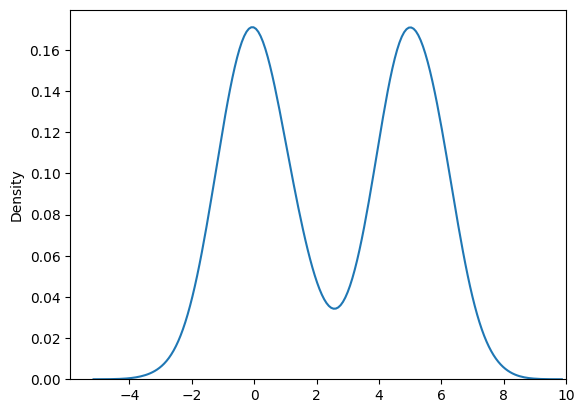

In [77]:
bimodal = norm_1 + norm_2
sns.kdeplot(bimodal)
plt.xlim(right=10)

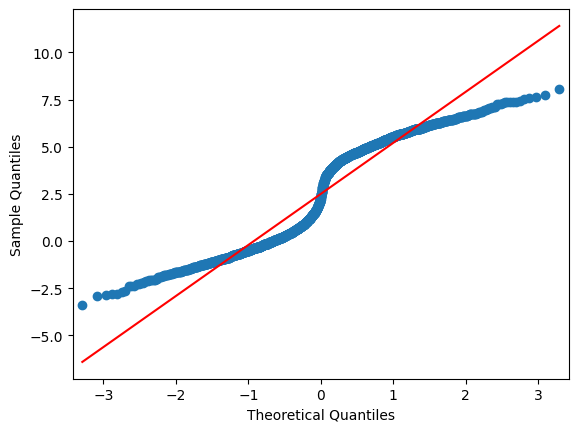

In [78]:
sm.qqplot(np.asarray(bimodal), line='s');

<img src="https://wagon-public-datasets.s3.amazonaws.com/04-Decision-Science/03-Linear-Regression/qq_plot_interpretation.png" width=400>

#### Check residuals vs. fitted to see if we can detect any non-random pattern

(0.0, 50.0)

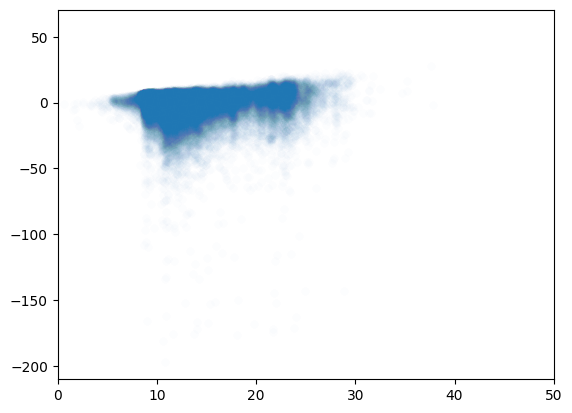

In [80]:
sns.scatterplot(x = y_pred, y = residuals_lewagon, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## More Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [ ]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
# Since we want the sum of product weights per order from our new DataFrame, we need to multiply weight by product count
order_items_products['product_weight_g'] = order_items_products['product_weight_g'] *  order_items_products['order_item_count']

order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [ ]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [ ]:
X2 = orders_with_details[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [ ]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [ ]:
X2['constant'] = 1

In [ ]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()